# Weighted Least Squares (WLS) Regression

A standard assumption in linear regression $Y = \beta_0 + \beta_1 x + Z$ is $\mathbb{E}\left[Z \vert X\right] = 0$ and $\mathbb{V}\left[Z \vert X\right] = \sigma^2$. When the latter is violated--that is, variance is non-constant across $x^{\left(i\right)}$, noise is heteroscedastic, and OLS is no longer the best linear unbiased estimator.

In the final part of this project, we will study the impact of heteroscedastic errors and a possible approach for rectifying it with weighted least squares. For this exercise, we use the synthetic dataset in **wls_data.csv** in the data directory. The data file contains two observed variables: 'x' and 'y'.

We will still assume $Z^{\left(i\right)}$ are independent, follow a Normal distribution, and $\mathbb{E}\left[Z \vert X\right] = 0$. However, we will not assume the errors are homoscedastic.

In [181]:
# Import the necessary libraries
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
import pandas as pd

plt.rc('font', size = 14)

In [182]:
# read the data
filen = 'data/wls_data.csv'
data = pd.read_csv(filen)
x = data['x'].values
y = data['y'].values
N = len(x)

# 1. OLS Regression
We will first build an OLS regression model. Note that we expect the estimated coefficients, $\hat{\beta_0}, \hat{\beta_1}$, to be unbiased estimators of $\beta_0, \beta_1$, due to the assumed properties of the errors. However, note that we have <b>not</b> assumed homoskedasticity (constant variance) of noise terms.

**(1a).** [1 pt] Build an OLS regression (using the <b>statsmodels.OLS</b> library). You do not have to fit the model in this step.

'y' is the dependent variable, and 'x' is the independent variable. You should add a constant to 'x' using the <b>add_constant()</b> function in statsmodels. Save the model as <b>ols_model</b>

In [183]:

ols_model = sm.regression.linear_model.OLS(y, sm.add_constant(x))

**(1b).** [1 pt] Fit the model using <b>ols_model.fit()</b> and save the result as <b>ols_results</b>.

In [184]:
ols_results = ols_model.fit()

**(1c).** [1 pt] Print the summary by calling <b>ols_results.summary()</b>.

In [185]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     3806.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          2.25e-235
Time:                        10:31:25   Log-Likelihood:                -1263.7
No. Observations:                 500   AIC:                             2531.
Df Residuals:                     498   BIC:                             2540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1393      0.136     15.757      0.000       1.873       2.406
x1             2.9014      0.047     61.694      0.000       2.809       2.994
==============================================================================
Omnibus:                       19.703   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.883
Skew:                           0.098   Prob(JB):                     6.60e-11
Kurtosis:                       4.487   Cond. No.                         2.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**(1d).** [1 pt] Compute the predictions, and store them as <b>ols_y_hat</b>. Use the <b>predict()</b> function with the parameters from <b>ols_results</b>. <br>
Check: http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.predict.html

In [186]:
ols_y_hat = ols_results.predict(sm.add_constant(x))

**(1e).** [1 pt] Compute the residuals. Store them as <b>ols_residuals</b>.

In [187]:
ols_residuals = y - ols_y_hat

**(1f).** [2 pts] On the same plot, produce the following:
1. Scatter plot of the data (x, y)
2. Plot (or scatter plot) of (x, ols_y_hat)

Label your plot and axes.

Text(0.5, 1.0, 'y vs x fit')

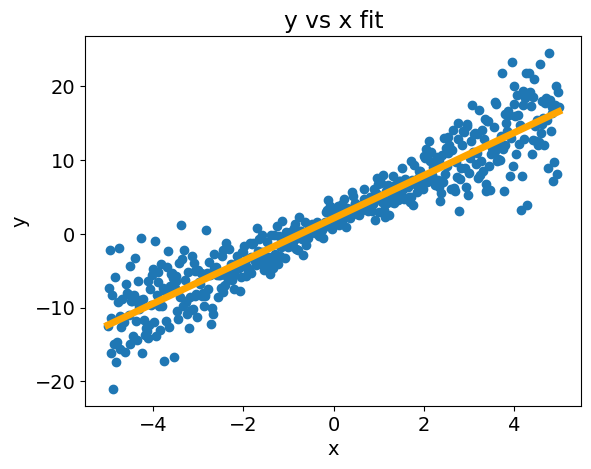

In [188]:
plt.scatter(x, y)
plt.plot(x, ols_y_hat, color='orange', linewidth=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('y vs x fit')

**(1g).** [1 pt] Comment on the fit produced.

**A:** The fit shows a strong correlation highlighted by an R^2 value of .884

**(1h).** [1 pt] Produce a scatter plot of the residuals vs 'x'. Label your plot and axes.

Text(0.5, 1.0, 'residuals vs x')

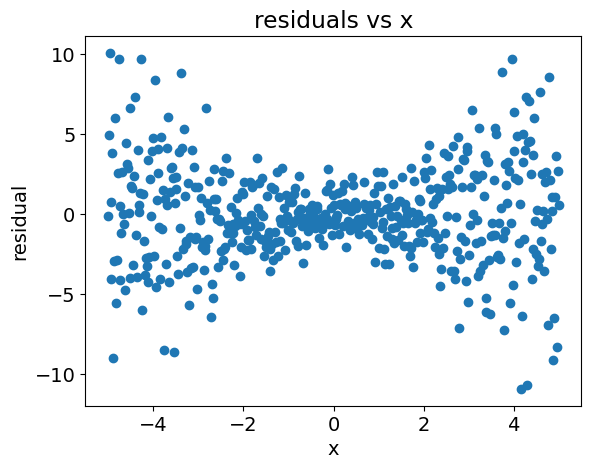

In [189]:
plt.scatter(x, ols_residuals)
plt.xlabel('x')
plt.ylabel('residual')
plt.title('residuals vs x')

**(1i).** [1 pt] What does this plot show? Is there evidence of constant variance (or otherwise)?

**A:** The plot shows that the variance of the residuals grows as the magnitude of x does giving evidence of non-constant variance

**(1j).** [1 pt] Now produce a QQ-plot of the residuals vs the Normal distribution.

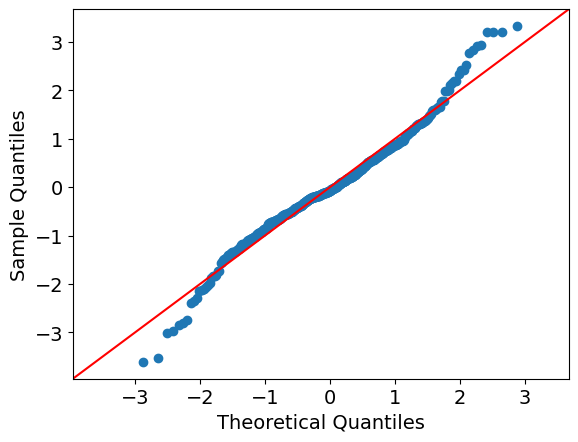

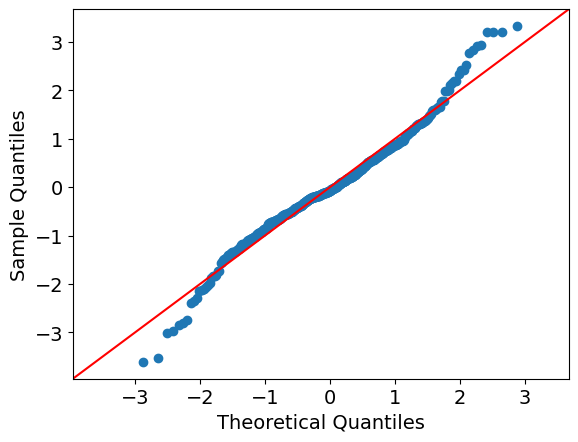

In [190]:
sm.qqplot(ols_residuals, stats.norm, fit=True, line="45")

**(1k).** [1 pt] Do the residuals appear Normally distributed?

**A:** Somewhat, although again the x values with largest magnitudes do deviate a decent amount from the fitted quantiles.

# 2. Weights Least Squares (WLS)

Given the apparent heteroscedasticity, we will use Weighted Least Squares to produce a better linear estimator. The weights are the variance at each data point. To understand why, we can look at the log likelihood from the inference perspective with Gaussian noise:

\begin{equation*}
    l\left(\beta_0, \beta_1, \sigma\right) = - \sum_{i=1}^n \log \sigma^{\left(i\right)} - \frac{1}{2} \sum_{i=1}^n \left(\frac{y^{\left(i\right)} - \left(\beta_0 + \beta_1 x^{\left(i\right)}\right)}{\sigma^{\left(i\right)}}\right)^2
\end{equation*}

We can compare this equation with the objective for WLS to see what the weights are for each sample:

\begin{equation*}
    \hat{\beta}_0, \hat{\beta}_1 = \arg\min_{\beta_0, \beta_1} \sum_{i=1}^n w^{\left(i\right)} \left(y^{\left(i\right)} - \beta_0 - \beta_1 x^{\left(i\right)}\right)^2
\end{equation*}

We see the weights are $\frac{1}{\sigma^{\left(i\right)2}}$. Note that when $\sigma^{\left(i\right)}$ are the same for all data points as in OLS, the samples have uniform weight. A challenge when implementing WLS is we are not provided information about the variance of each data point. Therefore, we first have to estimate the weights to eliminate hetereoscedasticity.

**(2a).** [2 pts] Write a function <b>estW()</b> to estimate the variance at each data point. This function takes the following inputs:
1. An array of OLS residuals
2. An array of 'x' values (corresponding to each residual)

The residuals are too variable to be used directly as the weights. Thus, we estimate the variance by predicting the squared residuals from $x^2$ with an intercept. Your function should return an array of estimates of the variance for each data point.

In [191]:
def estW(residuals, 
         x): 
    '''
    Estimate the variance for each data point by regressing the OLS residual^2 against x^2 and a constant.
    Use the regression parameters to produce estimated variances for each data point.
    @param residuals: np array, OLS residuals
    @param x: np array, samples
    @return: np array, estimated variances for each data point
    '''
    #square residuals and x
    squared_resid = residuals ** 2
    squared_x = x ** 2
    #fit model
    ols_results = sm.regression.linear_model.OLS(y, sm.add_constant(x)).fit()
    beta0, beta1 = ols_results.params
    #estimate variance with estimated residual
    est_var = (beta1 * squared_x + beta0)
    return est_var

**(2b).** [1 pt] Use the <b>estW(ols_residuals, x)</b> function to produce the estimates of the variances. Save these estimates of $\hat{\sigma}^{\left(i\right)2}$ as <b>sig_est</b>

In [192]:
sig_est = estW(ols_residuals, x)

**(2c).** [2 pts] On the same plot, produce the following in different colors:
1. Scatter plot of the absolute values of ols_residuals against x.
2. Plot (or scatterplot) of the square root of the variance estimates, i.e. each $\hat{\sigma}^{\left(i\right)}$ against $x^{\left(i\right)}$.

Label the plots and axes clearly.

Text(0.5, 1.0, 'residuals, variance vs x')

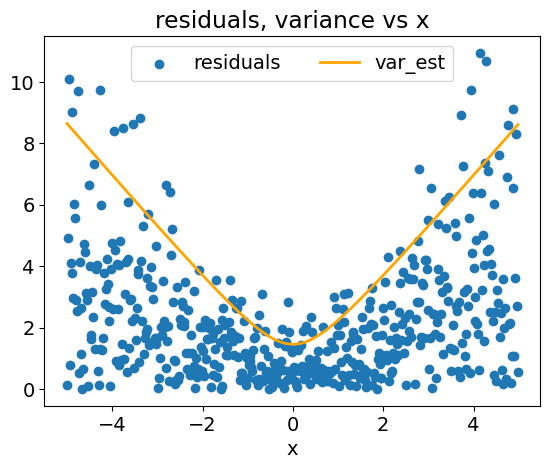

In [193]:
plt.scatter(x, abs(ols_residuals))
plt.plot(x, np.sqrt(sig_est), color='orange', linewidth=2)
plt.xlabel('x')
plt.legend(['residuals', 'var_est'], ncol=2)
plt.title('residuals, variance vs x')

**(2d).** [1 pt] What does the plot above show? Do you think the estimated residuals make sense?

**A:** The plot estimates residuals that grow as the magnitude of x increases which makes sense

**(2e).** [1 pt] The solution to WLS in the multi-variate linear regression case is

\begin{equation*}
    \hat{\beta} = \left(X^T V X\right)^{-1} X^T V Y
\end{equation*}

where $V$ is a matrix with diagonal entries $w^{\left(i\right)}$. Let $W$ be a matrix with diagonal entries $\sqrt{w^{\left(i\right)}}$. Observe that

\begin{equation*}
    \hat{\beta} = \left(\left(W X\right)^T \left(W X\right)\right)^{-1} \left(W X\right)^T \left(W Y\right)
\end{equation*}

This suggests we can find the WLS solution by solving OLS for $W X$ and $W Y$. We will first compute the diagonal entries of $W$ from the estimates of the variances. These entries are the <b>reciprocals of the square root of the variance estimates</b>. Store the diagonal entries of $W$ as <b>w</b>.

In [194]:
w = 1/np.sqrt(sig_est)

**(2f).** [1 pt] Now produce the following variables to set up the OLS problem:

1. <b>X</b> = independent variable (x) and a constant (use add_constant(x) from the statsmodels library). <br>
2. <b>W</b> = a matrix with the <b>w</b> array on the diagonal. <br>
3. <b>X_w</b> = the product of W and X <br>
4. <b>y_w</b> = the product of W and Y <br>

In [195]:
X = sm.add_constant(x)
W = np.diag(w)
X_w = W @ X
y_w = W @ y

**(2g).** [1 pt] Build an OLS regression (using the <b>statsmodels.OLS</b> library) with <b>y_w</b> and <b>X_w</b>. Save your model as <b>wls_model</b>. You do not need to fit the model in this step

In [196]:
wls_model = sm.regression.linear_model.OLS(y_w, X_w)

**(2h).** [1 pt] Similar to the OLS exercise above, fit the model. Then compute the predictions and residuals. Save them as <b>wls_results, wls_y_hat, wls_residuals</b>, respectively.

In [197]:
wls_results = wls_model.fit()
wls_y_hat = wls_results.predict(X_w)
wls_residuals = y_w - wls_y_hat

**(2i).** [1 pt] Print the summary of this regression.

In [198]:
wls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                              1886.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                   4.43e-233
Time:                        10:31:26   Log-Likelihood:                         -455.70
No. Observations:                 500   AIC:                                      915.4
Df Residuals:                     498   BIC:                                      923.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0629      0.080     25.644      0.000       1.905       2.221
x2             2.9433      0.053     55.822      0.000       2.840       3.047
==============================================================================
Omnibus:                        1.501   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.472   Jarque-Bera (JB):                1.573
Skew:                           0.101   Prob(JB):                        0.456
Kurtosis:                       2.814   Cond. No.                         1.53
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**(2j).** [1 pt] Show the scatter plot of these <b>wls_residuals</b> vs x. Is there still evidence of hetereoscedasticity?

Text(0.5, 1.0, 'wls_residuals vs x')

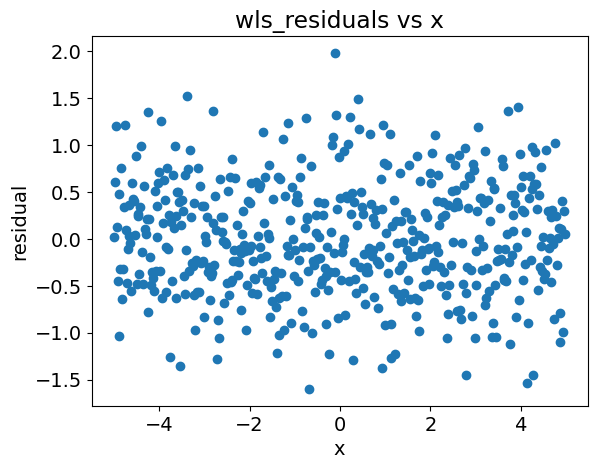

In [199]:
plt.scatter(x, wls_residuals)
plt.xlabel('x')
plt.ylabel('residual')
plt.title('wls_residuals vs x')

**A:** There is no more any evidence of hetereoscedasticity

**(2k).** [1 pt] Produce the QQ-plot of the <b>wls_residuals</b> vs the Normal distribution. Compared to the OLS residuals, is the Normal fit better? If so, how?

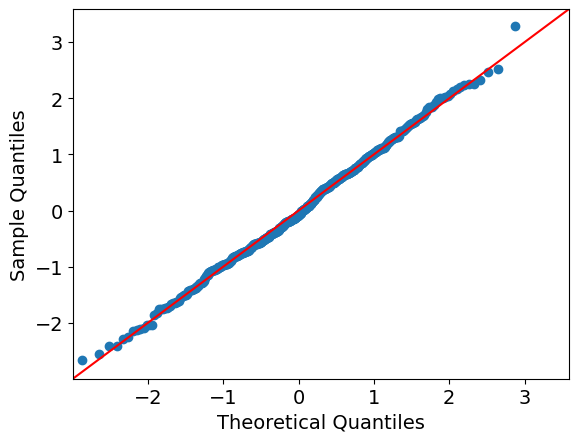

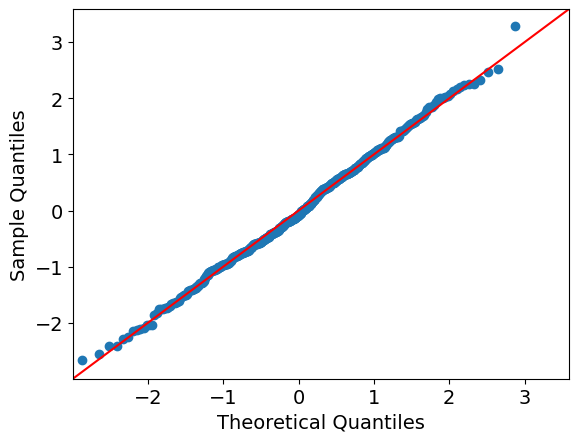

In [200]:
sm.qqplot(wls_residuals, stats.norm, fit=True, line="45")

**A:** The fit is much better now as there is only one point deviating from the line rather than multiple at either end

**(2l).** [1 pt] Since WLS is predicting $\widehat{w Y}$, transform the predictions back to $\hat{Y}$. Save the transformed predictions as <b>wls_y_hat_transformed</b>.

Hint: wls_y_hat_transformed = $W^{-1} \times$ wls_y_hat

In [201]:
wls_y_hat_transformed = np.linalg.inv(W) @ wls_y_hat

**(2m).** [2 pts] On the same plot, produce in different colors:
1. Scatter plot of the observed data (x, y)
2. Plot (or scatterplot) (x, wls_y_hat_transformed)

Label your plots and axes clearly.

Text(0.5, 1.0, 'y vs x wls fit')

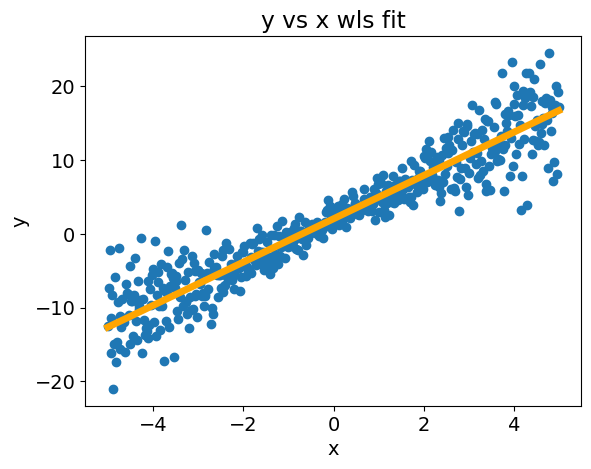

In [202]:
plt.scatter(x, y)
plt.plot(x, wls_y_hat_transformed, color='orange', linewidth=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('y vs x wls fit')

**(2n).** [2 pts] Using the WLS regression summaries and the plots, contrast the regression fit for OLS and WLS:
1. Are the coefficient estimates much different? Is that what you had expected?
2. Are the standard errors different? Is that what you had expected?

**A**: The coefficient estimates are not much different. Wasn't necessarily what I had expected given the severe heteroskedasticity, but perhaps the symmetrical nature of heteroskedasticity decreased the effect since the original line already bisected each end. The same goes for the standard errors which also don't differentiate much

<b>Note:</b> A more careful approach would do an 80/20 split on the data, where the 20% is used for inferring the pattern of the noise and the 80% is used to construct Weighted Least Squares. This would make these two inferences independent and would better resemble the case where the noise variances are deterministic known numbers (which are, of course, independent of the WLS regression procedure). You are welcome to try it out on your own and see what you get!